Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [betas]


Sampling 2 chains for 1_000 tune and 2_000 draw iterations (2_000 + 4_000 draws total) took 71 seconds.
We recommend running at least 4 chains for robust computation of convergence diagnostics


             mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  \
betas[0]    0.037  0.073  -0.094    0.177      0.001    0.001    5291.0   
betas[1]    0.058  0.071  -0.071    0.192      0.001    0.001    5508.0   
betas[2]    0.071  0.075  -0.070    0.212      0.001    0.001    5607.0   
betas[3]    0.059  0.086  -0.101    0.222      0.001    0.001    4823.0   
betas[4]   -0.054  0.083  -0.218    0.093      0.001    0.001    4830.0   
...           ...    ...     ...      ...        ...      ...       ...   
theta[995]  0.624  0.069   0.491    0.746      0.001    0.001    4778.0   
theta[996]  0.622  0.077   0.480    0.763      0.001    0.001    5209.0   
theta[997]  0.693  0.068   0.562    0.815      0.001    0.001    5429.0   
theta[998]  0.896  0.027   0.845    0.943      0.000    0.000    5234.0   
theta[999]  0.190  0.047   0.102    0.275      0.001    0.001    6010.0   

            ess_tail  r_hat  
betas[0]      3221.0    1.0  
betas[1]      2706.0    1.0  
betas[2] 

/opt/conda/lib/python3.11/site-packages/arviz/plots/plot_utils.py:270: UserWarning: rcParams['plot.max_subplots'] (40) is smaller than the number of variables to plot (1020) in plot_posterior, generating only 40 plots
  warnings.warn(
/opt/conda/lib/python3.11/site-packages/arviz/plots/plot_utils.py:270: UserWarning: rcParams['plot.max_subplots'] (40) is smaller than the number of variables to plot (2040) in plot_autocorr, generating only 40 plots
  warnings.warn(


array([[<Axes: title={'center': 'betas\n0, 0'}>,
        <Axes: title={'center': 'betas\n0, 1'}>,
        <Axes: title={'center': 'betas\n0, 2'}>,
        <Axes: title={'center': 'betas\n0, 3'}>],
       [<Axes: title={'center': 'betas\n0, 4'}>,
        <Axes: title={'center': 'betas\n0, 5'}>,
        <Axes: title={'center': 'betas\n0, 6'}>,
        <Axes: title={'center': 'betas\n0, 7'}>],
       [<Axes: title={'center': 'betas\n0, 8'}>,
        <Axes: title={'center': 'betas\n0, 9'}>,
        <Axes: title={'center': 'betas\n0, 10'}>,
        <Axes: title={'center': 'betas\n0, 11'}>],
       [<Axes: title={'center': 'betas\n0, 12'}>,
        <Axes: title={'center': 'betas\n0, 13'}>,
        <Axes: title={'center': 'betas\n0, 14'}>,
        <Axes: title={'center': 'betas\n0, 15'}>],
       [<Axes: title={'center': 'betas\n0, 16'}>,
        <Axes: title={'center': 'betas\n0, 17'}>,
        <Axes: title={'center': 'betas\n0, 18'}>,
        <Axes: title={'center': 'betas\n0, 19'}>],
     

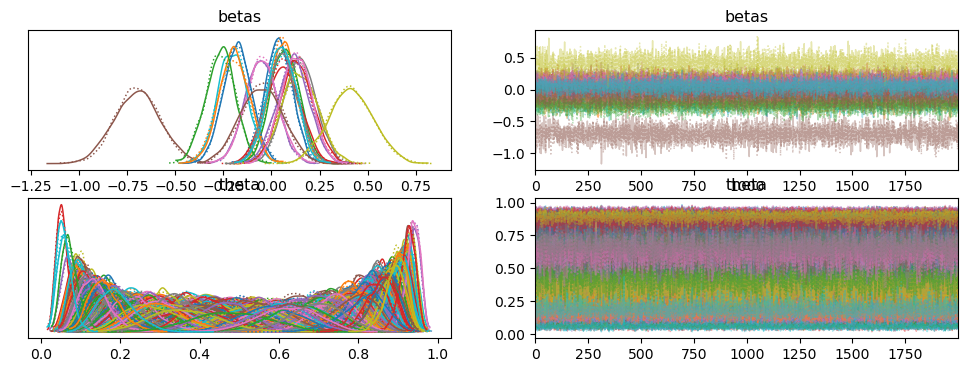

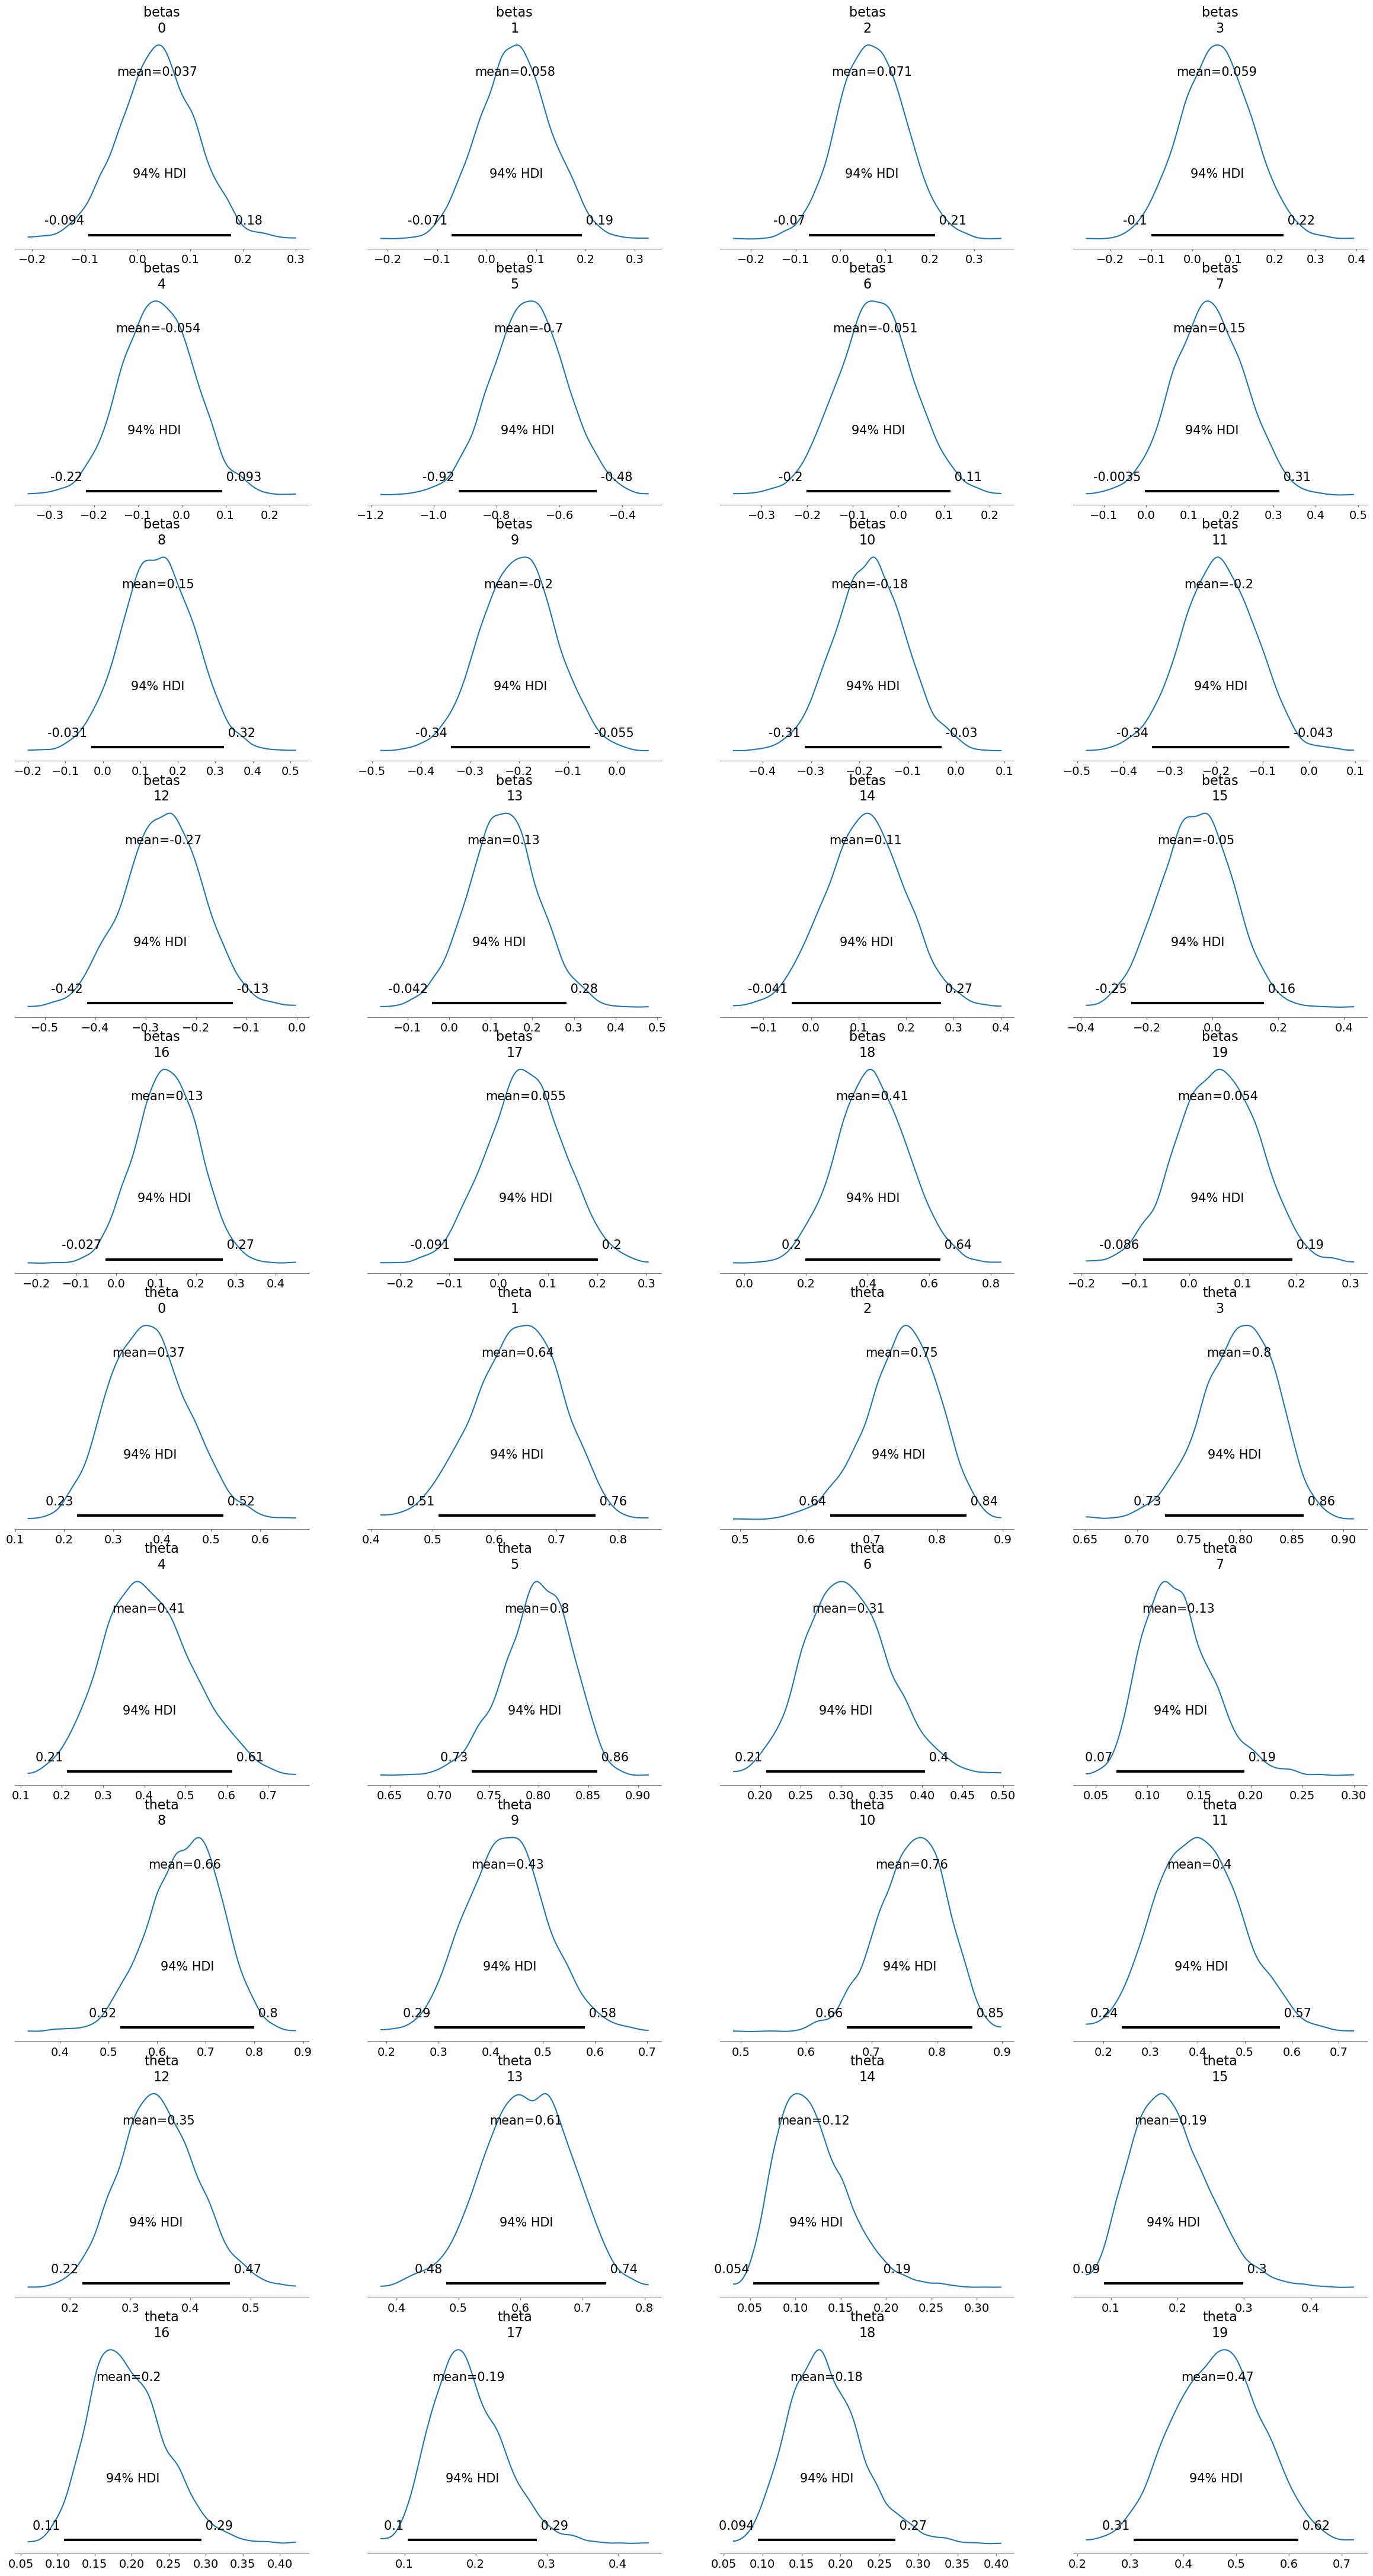

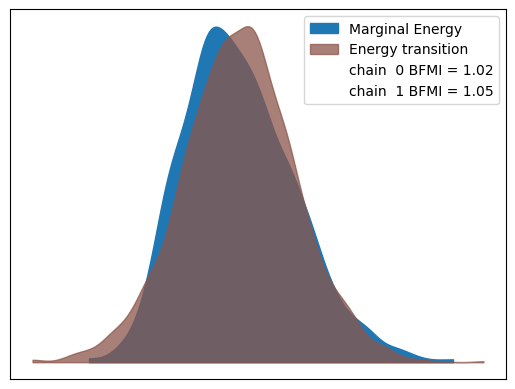

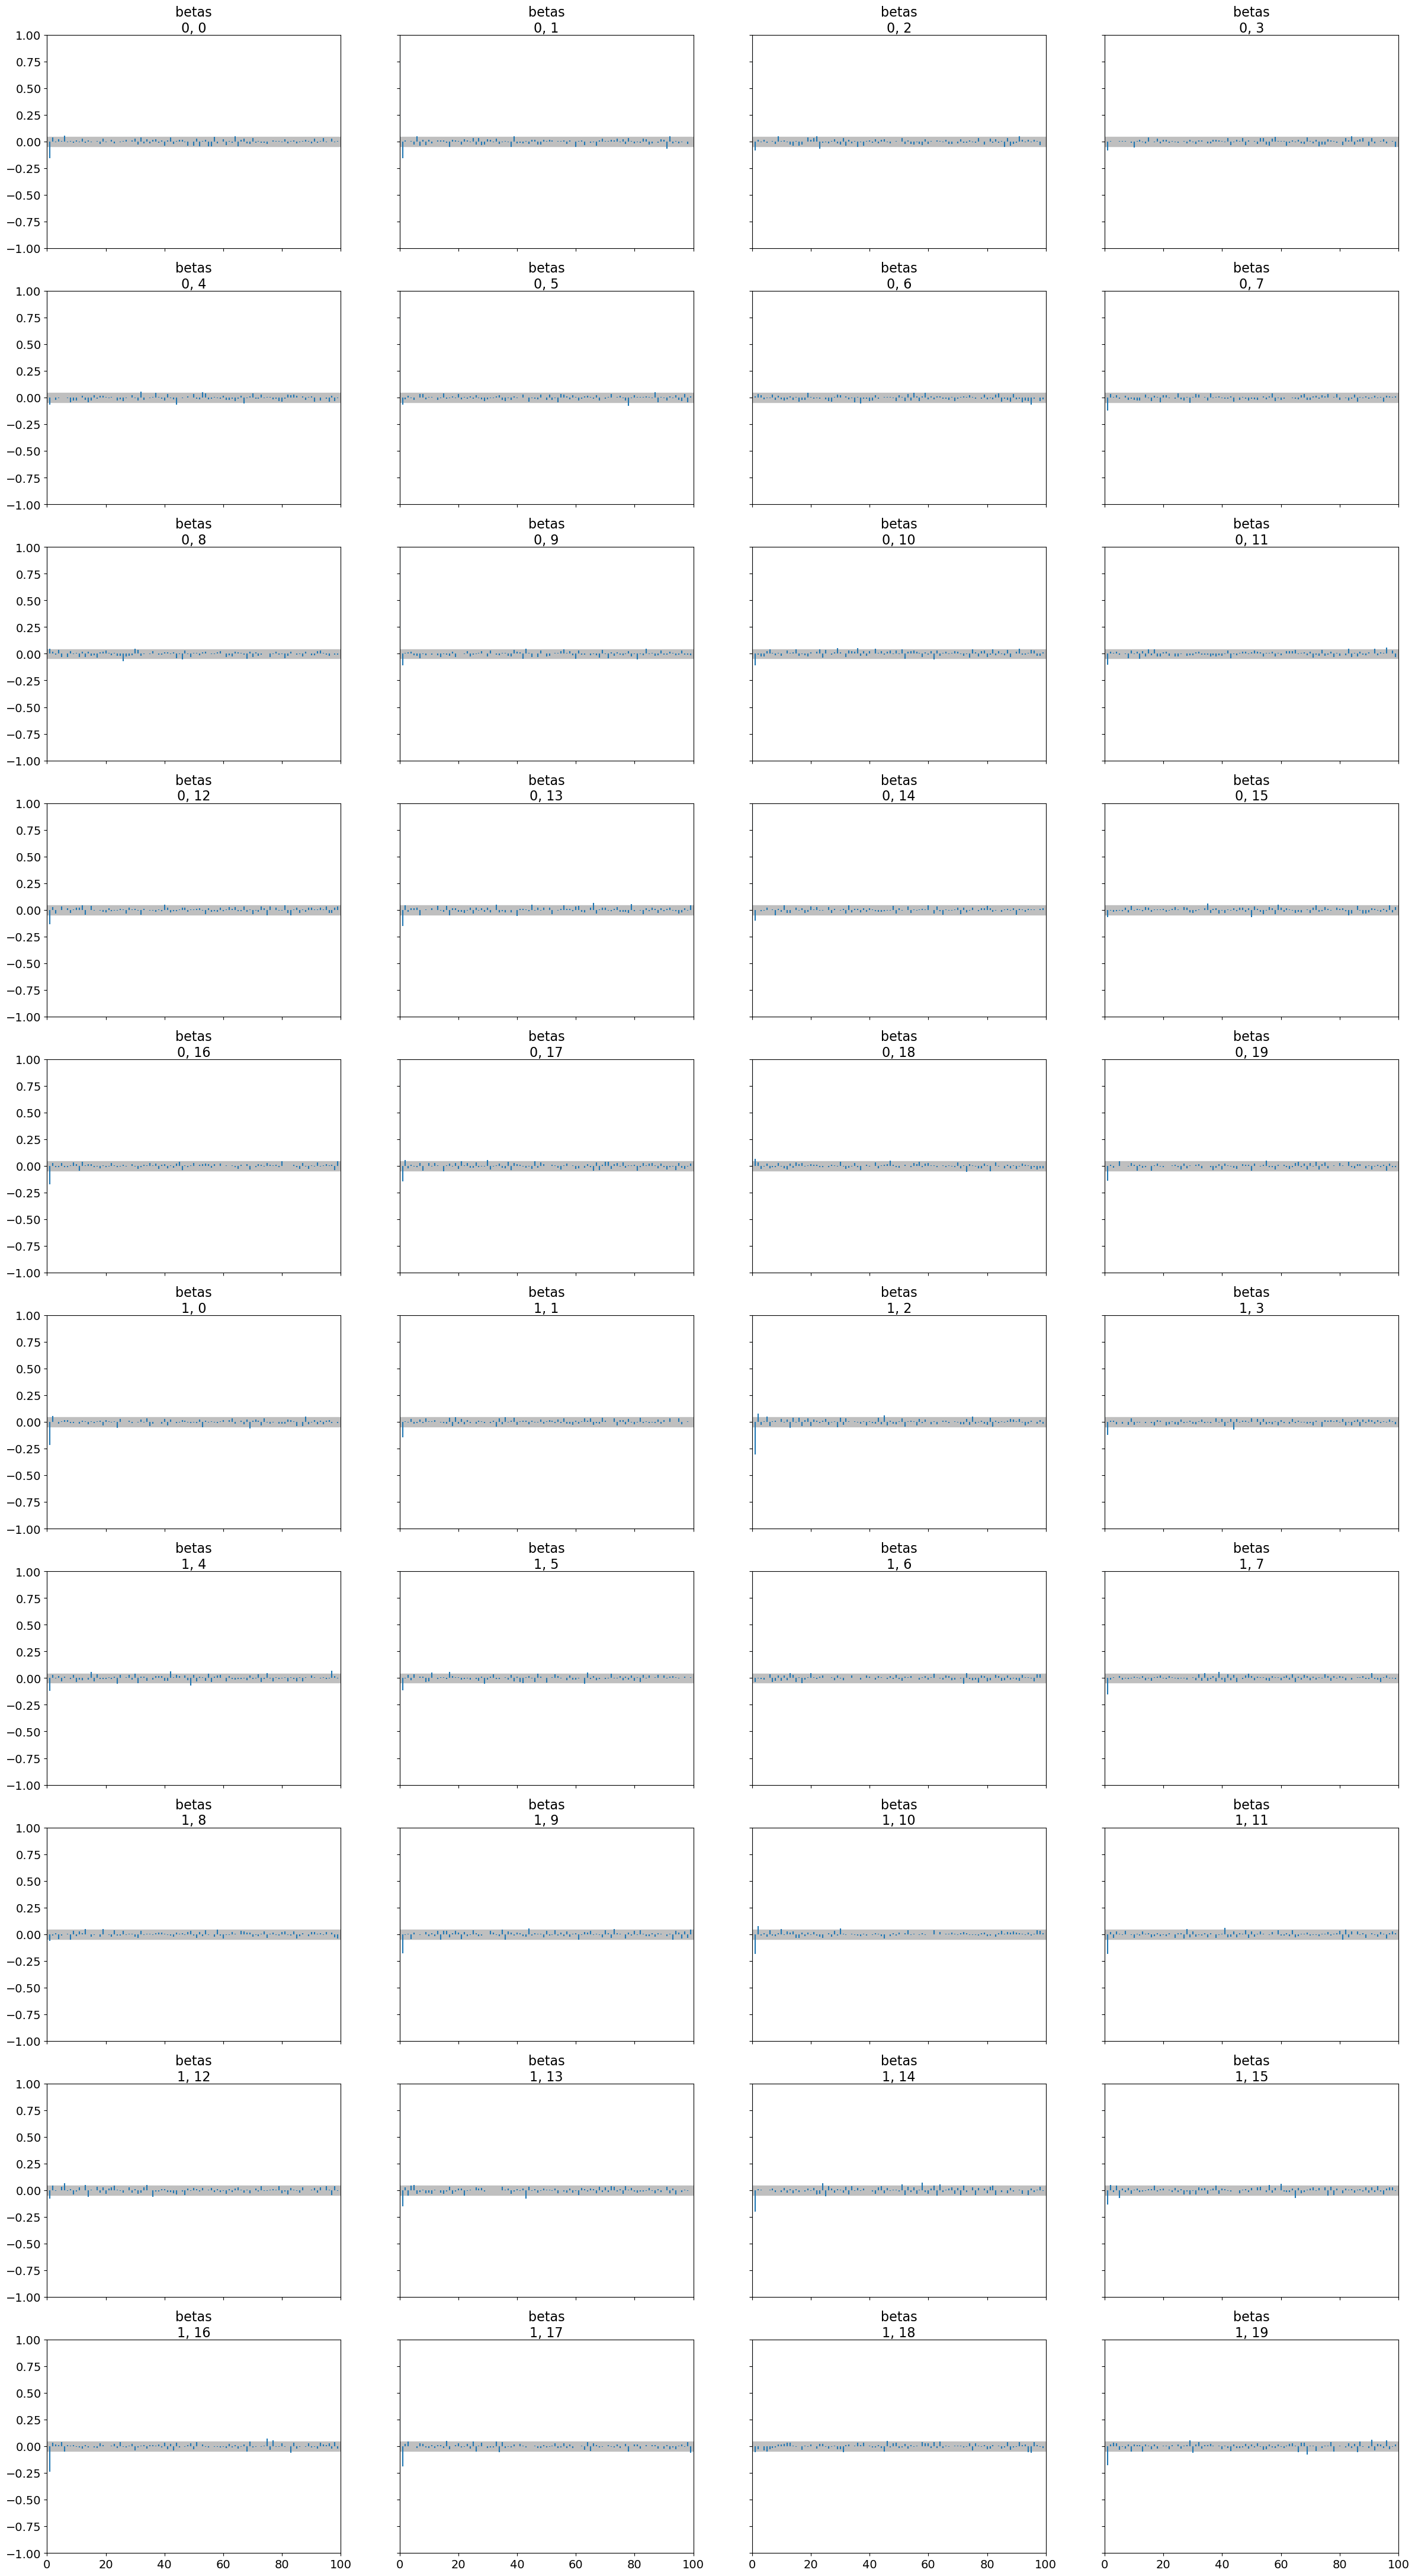

In [2]:
#Q1
#Telco Customer Churn
#https://www.kaggle.com/datasets/blastchar/telco-customer-churn

import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.model_selection import train_test_split
import pymc as pm
import arviz as az

# Load the dataset
data = pd.read_csv("WA_Fn-UseC_-Telco-Customer-Churn.csv")

# Encode categorical variables
label_encoders = {}
for col in data.select_dtypes(include=["object"]).columns:
    le = LabelEncoder()
    data[col] = le.fit_transform(data[col])
    label_encoders[col] = le  

# Correctly convert target variable to binary (1 = "Yes", 0 = "No")
data["Churn"] = (data["Churn"] == 1).astype(int)

# Standardize numerical features
scaler = StandardScaler()
numerical_cols = data.select_dtypes(include=["int64", "float64"]).columns
data[numerical_cols] = scaler.fit_transform(data[numerical_cols])

# Define features and target
X = data.drop(columns=["Churn"])
y = data["Churn"]

# Downsample for efficiency
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
X_train = X_train.iloc[:1000, :] 
y_train = y_train.iloc[:1000]

# Convert data to NumPy arrays for PyMC
X_train = X_train.to_numpy()
y_train = y_train.to_numpy()

n_features = X_train.shape[1]

# Bayesian Logistic Regression Model
with pm.Model() as logistic_model:
    # Priors for regression coefficients (regularization applied)
    betas = pm.Normal("betas", mu=0, sigma=0.5, shape=n_features)

    # Linear combination (dot product)
    linear_combination = pm.math.dot(X_train, betas)

    # Logit link function
    theta = pm.Deterministic("theta", pm.math.sigmoid(linear_combination))

    # Likelihood (Bernoulli distribution)
    y_obs = pm.Bernoulli("y_obs", p=theta, observed=y_train)

    # Sample from the posterior using NUTS (default)
    trace = pm.sample(
        2000, tune=1000, target_accept=0.9, cores=2, random_seed=1007818630, return_inferencedata=True
    )

# Summarize posterior distributions
summary = az.summary(trace)
print(summary)

# Plot posterior distributions and trace plots
az.plot_trace(trace)
az.plot_posterior(trace)

# MCMC diagnostics
az.plot_energy(trace)
az.plot_autocorr(trace)


In Q1, we performed Bayesian Logistic Regression to model a binary outcome using a Bernoulli likelihood with a logit link function. The posterior results show small but varied regression coefficients, with some crossing zero, indicating weak predictor influence. Effective sample sizes are high, and R-hat values of 1.0 confirm good convergence. The posterior probabilities suggest some confident classifications but also areas of uncertainty. While the model performs well, feature selection or transformations could improve predictive accuracy.

Available Columns in Dataset:
 ['Hours Studied', 'Previous Scores', 'Extracurricular Activities', 'Sleep Hours', 'Sample Question Papers Practiced', 'Performance Index']

Encoding categorical variables: ['Extracurricular Activities']


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [betas, sigma]


Sampling 2 chains for 1_000 tune and 2_000 draw iterations (2_000 + 4_000 draws total) took 4 seconds.
We recommend running at least 4 chains for robust computation of convergence diagnostics



Bayesian Linear Regression Results:
            mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  \
betas[0]   2.012  0.808   0.534    3.552      0.011    0.014    5473.0   
betas[1]   6.192  0.834   4.718    7.829      0.012    0.014    4910.0   
betas[2]  -0.810  0.835  -2.430    0.686      0.011    0.013    5974.0   
betas[3]  -0.425  0.829  -1.888    1.209      0.011    0.013    5702.0   
betas[4]   0.361  0.829  -1.221    1.936      0.011    0.015    5744.0   
sigma     32.276  0.439  31.487   33.124      0.006    0.007    5611.0   

          ess_tail  r_hat  
betas[0]    2636.0    1.0  
betas[1]    3078.0    1.0  
betas[2]    3099.0    1.0  
betas[3]    2987.0    1.0  
betas[4]    2852.0    1.0  
sigma       2724.0    1.0  


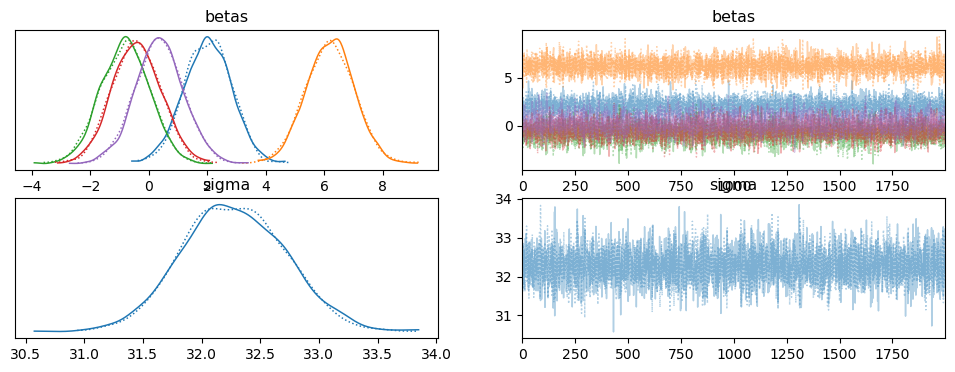

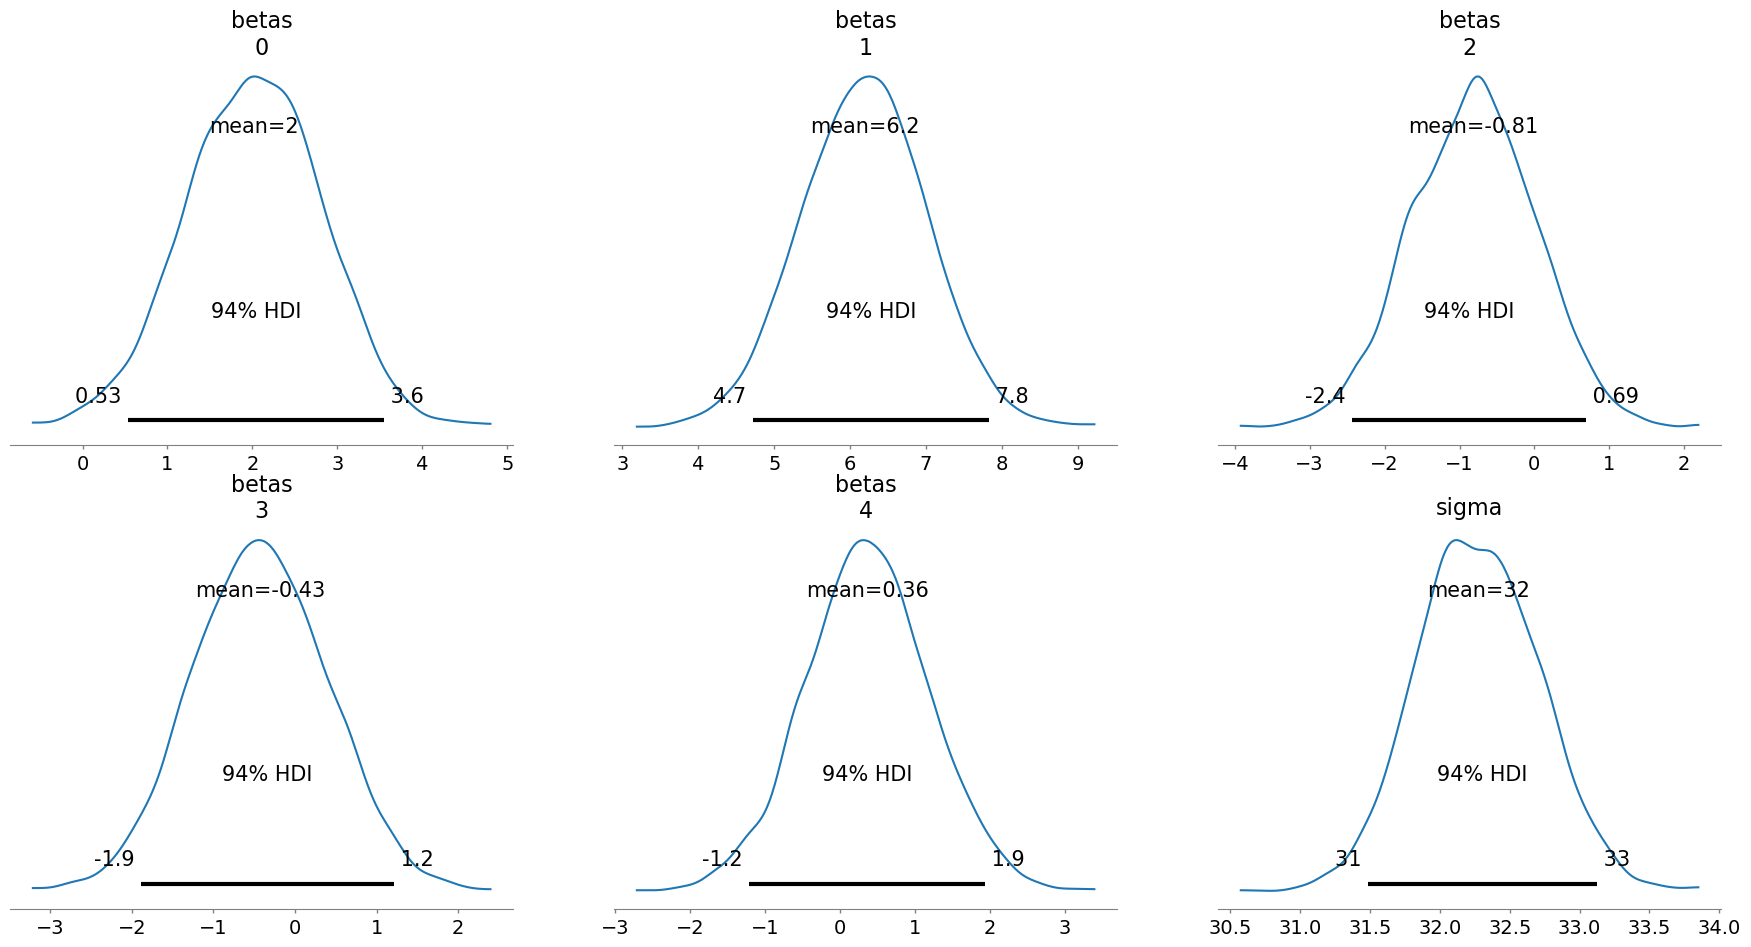

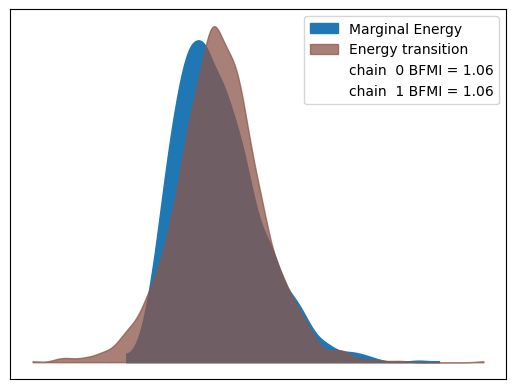

In [7]:
#Q2
#https://www.kaggle.com/datasets/nikhil7280/student-performance-multiple-linear-regression
#Student Performance

import pandas as pd
import numpy as np
import pymc as pm
import arviz as az
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler, OneHotEncoder

df = pd.read_csv("Student_Performance.csv")

# Strip whitespace from column names
df.columns = df.columns.str.strip()

# Display dataset info for debugging
print("Available Columns in Dataset:\n", df.columns.tolist())

# Define feature columns and target variable
X_columns = ["Hours Studied", "Previous Scores", "Extracurricular Activities", "Sleep Hours", "Sample Question Papers Practiced"]
y_column = "Performance Index"

# Handle missing values
df = df.dropna()

# Identify categorical and numerical columns
categorical_cols = ["Extracurricular Activities"]
numerical_cols = [col for col in X_columns if col not in categorical_cols]

# One-Hot Encode categorical variables
if categorical_cols:
    print("\nEncoding categorical variables:", categorical_cols)
    encoder = OneHotEncoder(drop='first', sparse_output=False)
    encoded_cats = encoder.fit_transform(df[categorical_cols])
    
    # Convert to DataFrame and add column names
    encoded_df = pd.DataFrame(encoded_cats, columns=encoder.get_feature_names_out(categorical_cols))
    
    # Drop original categorical columns and concatenate encoded ones
    df = df.drop(columns=categorical_cols)
    df = pd.concat([df, encoded_df], axis=1)

# Update feature list after encoding
X_columns = [col for col in df.columns if col != y_column]  

# Extract data
X = df[X_columns].values
y = df[y_column].values  

# Standardize numerical features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Downsample data to improve MCMC efficiency
X_downsampled = X_scaled[:500, :]  
y_downsampled = y[:500]  

# Get dimensions
n_samples, n_features = X_downsampled.shape

# Define Bayesian Linear Regression Model
with pm.Model() as model:
    # Priors for regression coefficients
    betas = pm.Normal("betas", mu=0, sigma=1, shape=n_features)
    sigma = pm.HalfNormal("sigma", sigma=1)

    # Expected value of outcome (Linear combination)
    mu = pm.math.dot(X_downsampled, betas)

    # Likelihood (Normal distribution)
    y_obs = pm.Normal("y_obs", mu=mu, sigma=sigma, observed=y_downsampled)

    # Sample from the posterior using NUTS
    trace = pm.sample(2000, tune=1000, target_accept=0.9, cores=2, random_seed=1007818630, return_inferencedata=True)

# Summarize Results
print("\nBayesian Linear Regression Results:")
print(az.summary(trace, var_names=['betas', 'sigma']))

# Visualize Posterior Distributions & Diagnostics
az.plot_trace(trace, var_names=['betas', 'sigma'])
plt.show()
az.plot_posterior(trace, var_names=['betas', 'sigma'])
plt.show()
az.plot_energy(trace)
plt.show()


In Q2, we performed Bayesian Multivariate Regression using PyMC, applying Normal priors to regression coefficients and a Half-Normal prior to residual variance. The model showed good convergence, with all R-hat values at 1.0 and high effective sample sizes. The second predictor had a strong positive effect, while others had minimal impact. The residual standard deviation of 32.3 suggests considerable unexplained variance, indicating potential missing predictors or non-linear relationships. While the model performed well, improvements could include feature selection, transformations, or hierarchical modeling to enhance predictive accuracy.

Auto-assigning NUTS sampler...
Initializing NUTS using adapt_diag...
Sequential sampling (2 chains in 1 job)
NUTS: [betas, chol, z]


Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 803 seconds.
We recommend running at least 4 chains for robust computation of convergence diagnostics


Posterior Summary Statistics:
              mean     sd  hdi_2.5%  hdi_97.5%  mcse_mean  mcse_sd  ess_bulk  \
betas[0, 0]  0.288  0.215    -0.108      0.698      0.012    0.007     315.0   
betas[0, 1] -1.922  0.549    -2.922     -1.071      0.238    0.077       5.0   
betas[0, 2] -0.956  0.356    -1.619     -0.345      0.042    0.038      84.0   
betas[1, 0]  0.166  0.214    -0.280      0.566      0.014    0.009     232.0   
betas[1, 1]  0.280  0.239    -0.207      0.746      0.019    0.022     148.0   
betas[1, 2]  0.030  0.266    -0.483      0.564      0.015    0.007     305.0   
betas[2, 0]  0.689  0.227     0.264      1.139      0.020    0.008     131.0   
betas[2, 1]  0.364  0.171     0.056      0.715      0.024    0.014      56.0   
betas[2, 2]  0.173  0.234    -0.317      0.619      0.011    0.007     487.0   
betas[3, 0] -0.117  0.201    -0.477      0.309      0.010    0.010     383.0   
betas[3, 1]  0.544  0.254     0.100      1.103      0.059    0.025      19.0   
betas[3, 2

Sampling: [y_obs]



Posterior Predictive Checks:

Overall Prediction Accuracy: 79.56%


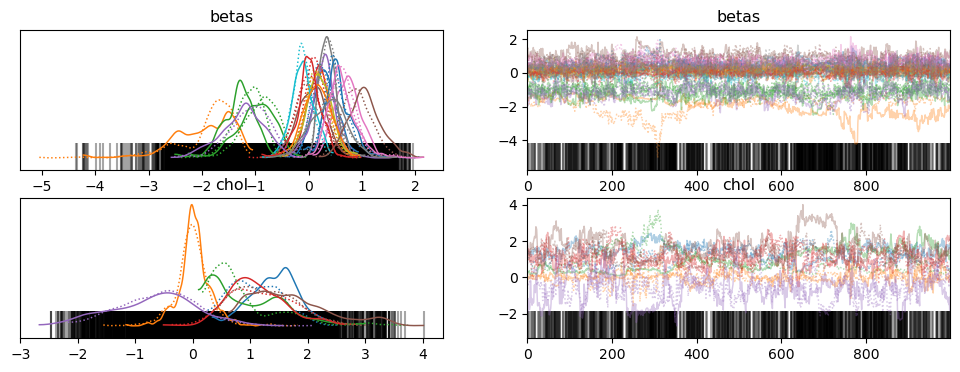

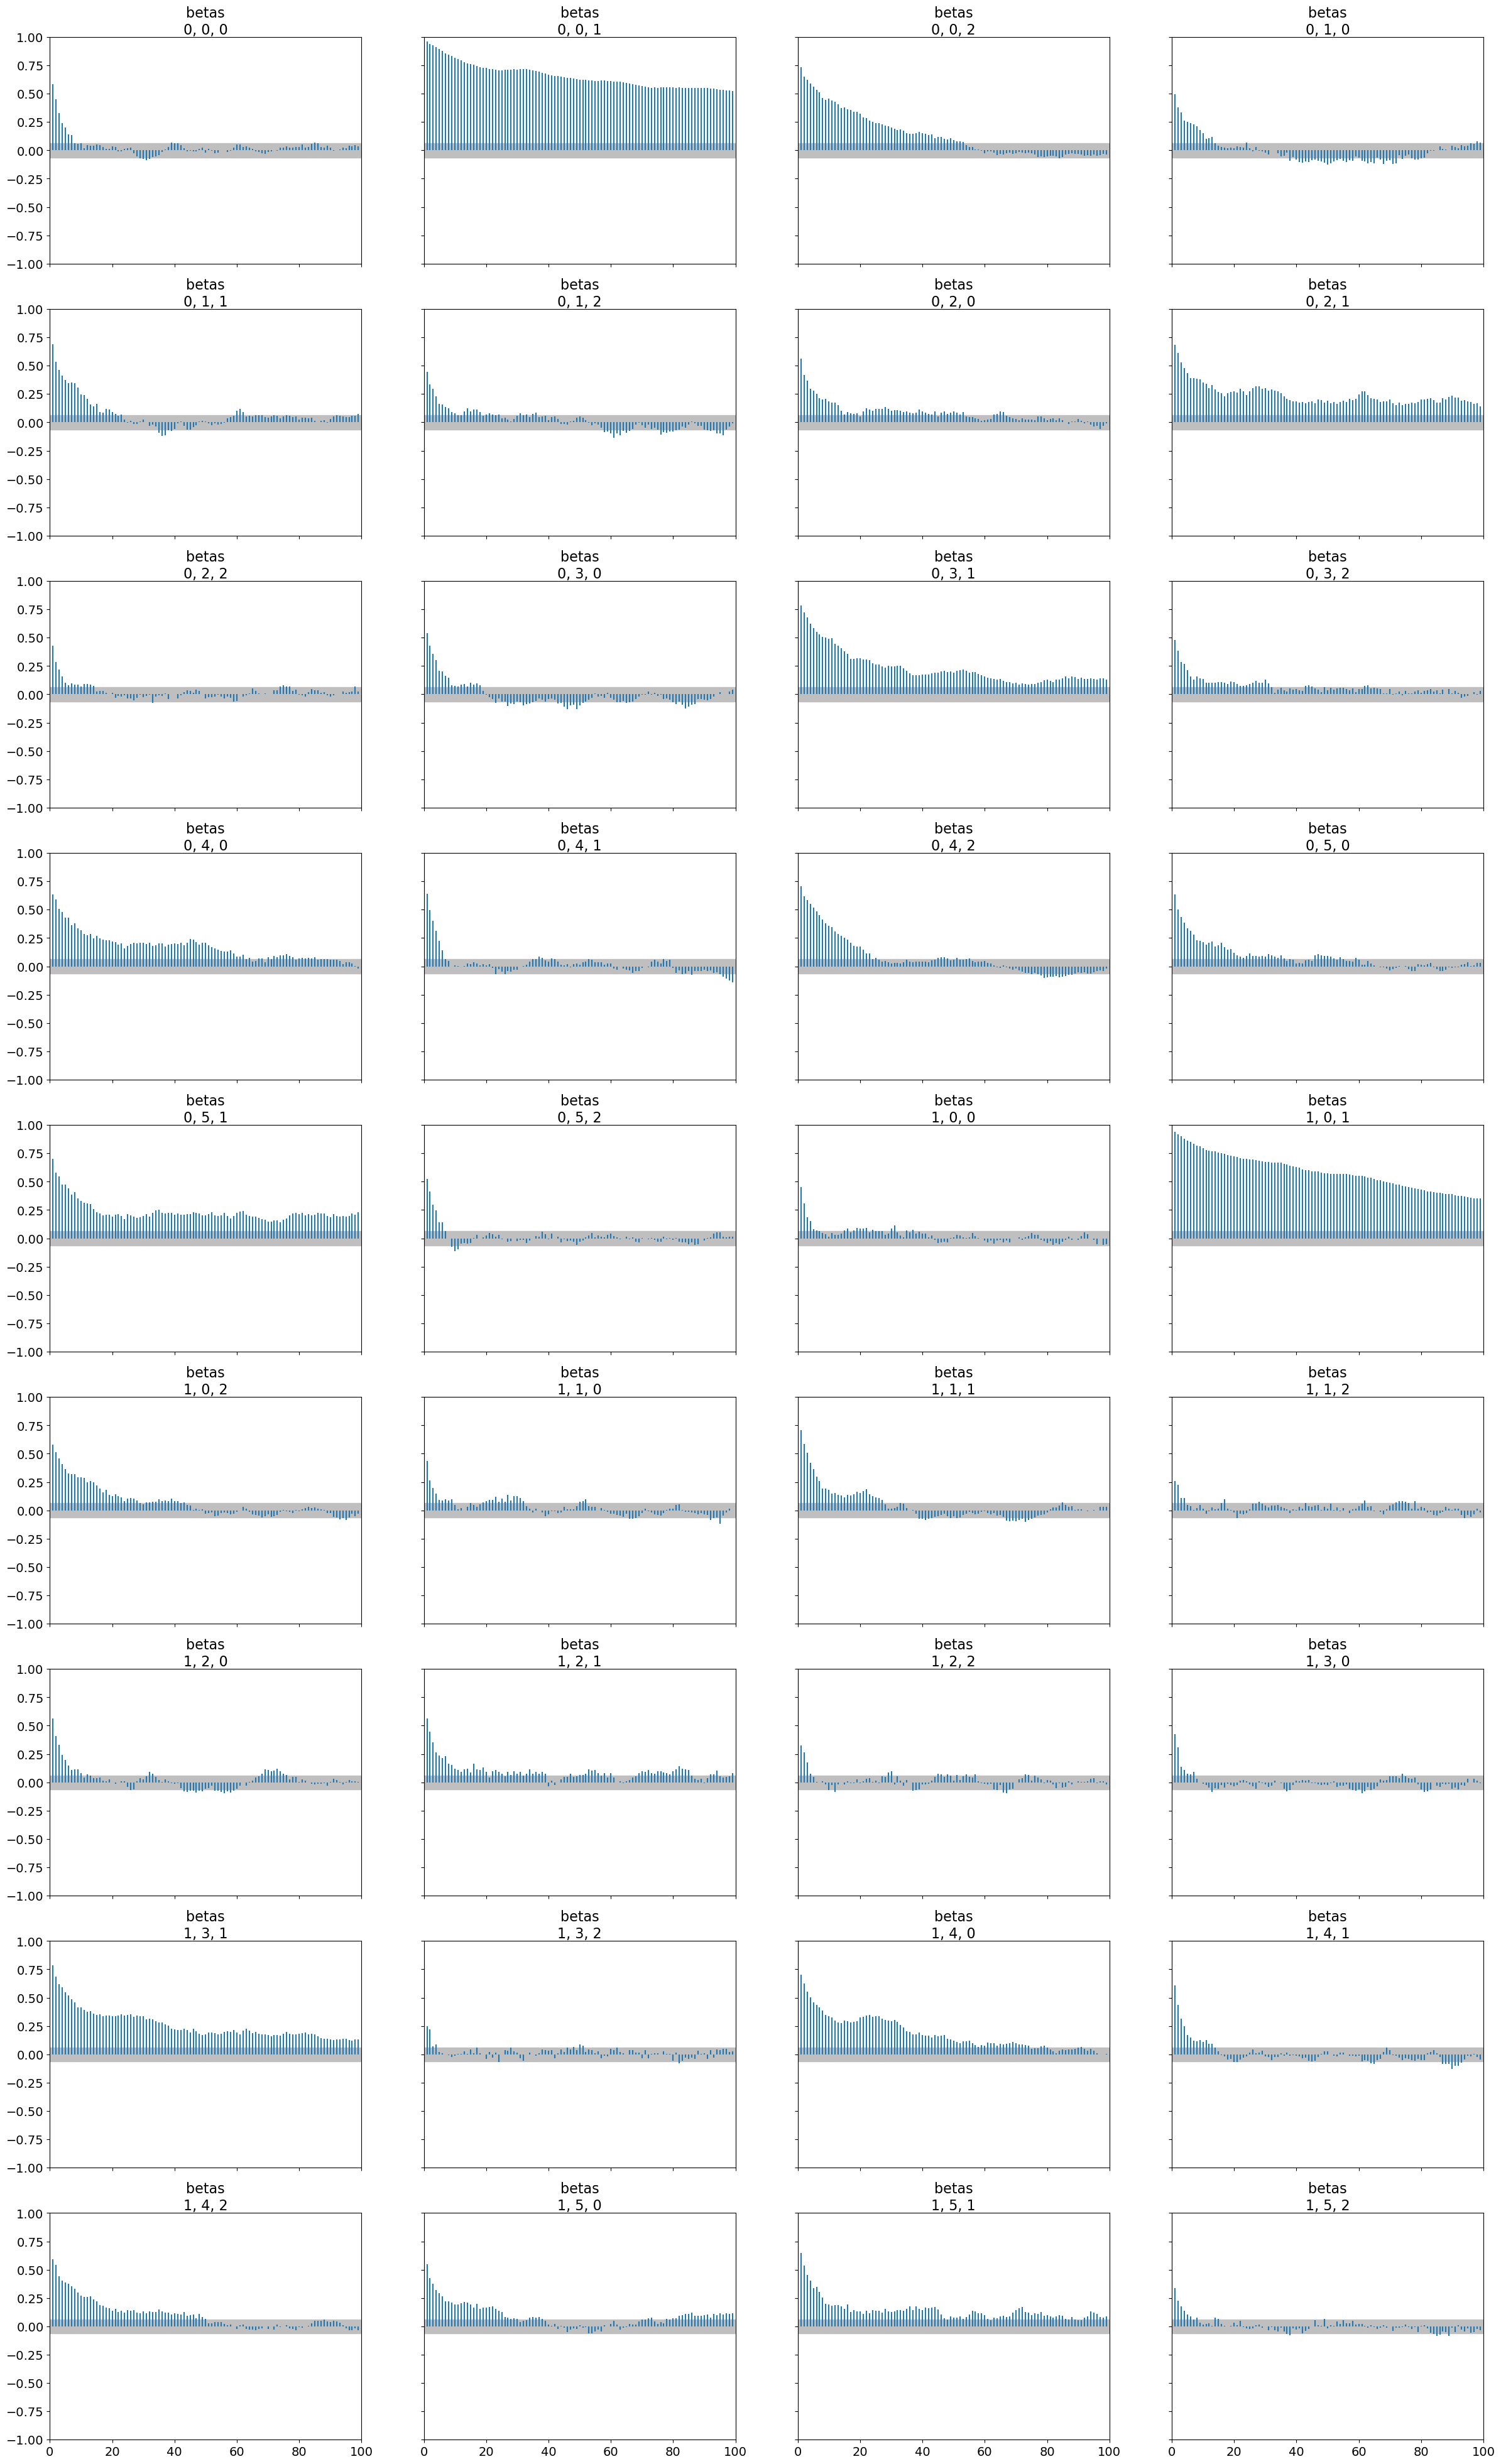

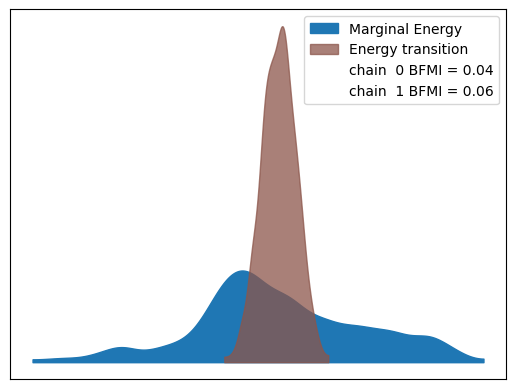

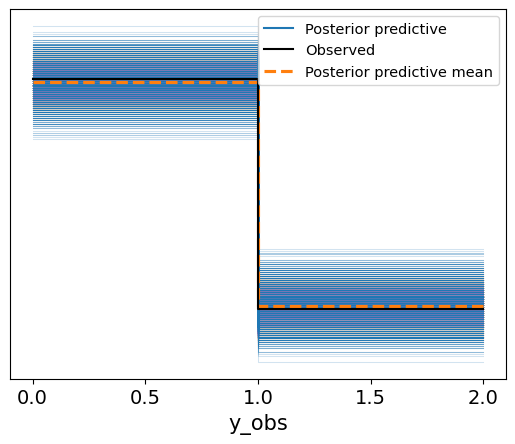

In [34]:
#Q3
#https://www.kaggle.com/datasets/redwankarimsony/heart-disease-data
#UCI Heart Disease Data

import numpy as np
import pandas as pd
import pymc as pm
import arviz as az
import pytensor.tensor as pt
from sklearn.preprocessing import StandardScaler, LabelEncoder


data = pd.read_csv("heart_disease_uci.csv")

# Create multiple binary targetstarget_cols 
for col in target_cols:
    data[col] = np.where(data[col] > 0, 1, 0)  

# Handle missing values
data = data.fillna(data.median(numeric_only=True))

# Encode categorical variablescat_cols
for col in cat_cols:
    le = LabelEncoder()
    data[col] = le.fit_transform(data[col].astype(str))

# Select feature columns
numeric_cols = data.select_dtypes(include=np.number).columns.difference(target_cols)
X_full = data[numeric_cols].values
y_full = data[target_cols].values

# Standardize features
scaler = StandardScaler()
X_full = scaler.fit_transform(X_full)

# Downsampling Exploration (n=150, p=5, m=3)
np.random.seed(1007818630)
sample_idx = np.random.choice(X_full.shape[0], 150, replace=False)
X = X_full[sample_idx, :5]  
y = y_full[sample_idx, :3] 
n, p = X.shape
m = y.shape[1]

X = np.c_[np.ones(n), X]  # (n, p+1)
p += 1

# Bayesian Multivariate Classification Model
with pm.Model() as model:
    betas = pm.Normal("betas", mu=0, sigma=1, shape=(p, m))
    
    chol, corr, stds = pm.LKJCholeskyCov(
        "chol", 
        n=m,         
        eta=2.0,     
        sd_dist=pm.Exponential.dist(1.0)  
    )
    
    # Latent variable structure
    mu = pt.dot(X, betas)  # (n, m)
    
    z = pm.MvNormal(
        "z", 
        mu=mu, 
        chol=chol,    
        shape=(n, m)  
    )
    
    # Probit link function
    p_prob = pm.math.invprobit(z)
    
    # Observation likelihood
    y_obs = pm.Bernoulli("y_obs", p=p_prob, observed=y)
    
    # MCMC Sampling
    trace = pm.sample(
        draws=1000,
        tune=1000,
        chains=2,
        target_accept=0.9,
        init="adapt_diag",
        random_seed=1007818630,
        cores=1
    )

# Diagnostic Analysis
# Posterior summary statistics
print("Posterior Summary Statistics:")
print(az.summary(trace, var_names=["betas", "chol"], hdi_prob=0.95))

# Trace plots
az.plot_trace(trace, var_names=["betas", "chol"])
pm.model_to_graphviz(model)

# Autocorrelation analysis
az.plot_autocorr(trace, var_names=["betas"])

# Energy plot
az.plot_energy(trace)

# Posterior Predictive Checks
with model:
    ppc = pm.sample_posterior_predictive(trace, var_names=["y_obs"])
    
print("\nPosterior Predictive Checks:")
az.plot_ppc(ppc)

# Model Evaluation
beta_post = trace.posterior["betas"].mean(("chain", "draw")).values
z_pred = X @ beta_post
y_pred = (z_pred > 0).astype(int)
accuracy = (y_pred == y).mean()
print(f"\nOverall Prediction Accuracy: {accuracy:.2%}")

In Q3, the Bayesian multivariate classification model was applied to the heart disease dataset using PyMC, incorporating normal priors for regression coefficients and an LKJ prior for the covariance structure. While the model achieved an overall classification accuracy of 79.56%, it exhibited convergence issues, with low effective sample sizes and high R-hat values for some parameters. The presence of divergences suggests numerical instability, indicating the need for further adjustments in model specification or priors to improve sampling efficiency.